<a href="https://colab.research.google.com/github/kqian23/amazon_capstone_project/blob/main/Analysis_MSBA_Team_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSBA Capstone Project - Storage Classification
## Master of Science in Business Analytics 2021, Michael G. Foster School of Business

**Project Sponsor & Mentor**: Lucas A. Meyer
 

**Team Members**
- [Alex Arthur](https://www.linkedin.com/in/alexarthur93/)
- Brett Penfold
- [Chuck R Christian](https://www.linkedin.com/in/cchrist5/)
- [Jia Hua](https://www.linkedin.com/in/jia-gia-hua-9b71909b/)
- [Kunpei Peng](https://www.linkedin.com/in/kunpeipeng/)
- [Kun Qian](https://www.linkedin.com/in/kunq/)


In this script is a detailed review of our methods and findings related to the search for a model that would categorize incoming products faster and more accurately than the average human.

For questions and further support please feel free to contact any of those listed above using the information provided.

⚠️**Before Running**

If you're running the script in Google Colab, you'll need to either upload the 2 data files: *categorization.csv* and *labels.csv* under the 'Files' tab in the left side bar, or store the data files in your google drive and connect this script with your drive by clicking the 'Mount Drive' icon located in the 'Files' tab.

You can also save this script as ipynb, and open in your own IDE. 

In [ ]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from google.colab import data_table # The data_table function is specifically for the use in Google Colab. If you're using other IDE, another function may be required
%load_ext google.colab.data_table 
from itertools import chain

# Model
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer, precision_score, recall_score, precision_recall_fscore_support, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# NLP
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import re, string
from wordcloud import WordCloud, STOPWORDS
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# 1. Data Preparation

### 1.1 Import Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone_data/Original Data/categorization.csv')
df.shape

(618342, 11)

In [ ]:
# uncomment to display the original dataframe
# data_table.DataTable(df)

### 1.2 Function Preparation: Text Cleaning

Define text cleaning functions for later use, you can skip this section for now





In [ ]:
# remove pure numbers
def remove_nums(column):
    return ' '.join(s for s in column.split() if not s.isnumeric())

# remove any token that has digit 
def remove_wordnums(column):
    return ' '.join(s for s in column.split() if not any(c.isdigit() for c in s))

# remove word nums longer than 3 characters
def remove_long_wordnums(column):
    return ' '.join(s for s in column.split() if not (any(c.isdigit() for c in s) and len(str(s))>3))

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i) < 128)

def remove_single_chars(column):
    return ' '.join([w for w in column.split() if len(w) > 1])

def remove_punctuation(text):
    punctuations = '''!()'?@#$%’"&'*+,-./:;<=>?@[\]^_`{|}~'''
    # remove punctuation from the string
    no_punct = ""
    for char in text:
      if char not in punctuations:
          no_punct = no_punct + char
    return no_punct

def remove_nonenglish(column):
    return " ".join(w for w in nltk.wordpunct_tokenize(column) \
                    if w.lower() in words or not w.isalpha())


The lemmatization function needs some special care. Since it treats nouns, verbs, and adjectives differently, we create the following function to identify and correctly lemmatize based on a word's type.

In [ ]:
# Define function to lemmatize each word with its part-of-speech (POS) tag
def pos_tagger(nltk_tag):
	if nltk_tag.startswith('J'):
		return wordnet.ADJ
	elif nltk_tag.startswith('V'):
		return wordnet.VERB
	elif nltk_tag.startswith('N'):
		return wordnet.NOUN
	elif nltk_tag.startswith('R'):
		return wordnet.ADV
	else:		
		return None

lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize(text):
  # tokenize the sentence and find the POS tag for each token
  pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
  # we use our own pos_tagger function to make things simpler to understand.
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
    if tag is None:
      # if there is no available tag, append the token as is
      lemmatized_sentence.append(word)
    else:		
      # else use the tag to lemmatize the token
      lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  lemmatized_sentence = " ".join(lemmatized_sentence)
  return lemmatized_sentence


# This simplified version treats every words as noun
def simple_lemmatize(text):
  return " ".join([lemmatizer.lemmatize(x) for x in nltk.word_tokenize(text)])

## 1.3 Data Cleaning

**Drop Duplicates**

61.02% of the samples are exactly the same. After dropping duplicates, the size of the sample shrinks from 618342 to 241005

In [ ]:
# drop duplicates
df_bow = df.drop_duplicates()  # reduce to 241005 rows

**Remove rows with too much empty cells**

This step removes 43160 rows with only two non-empty columns (mostly just 'ASIN' and temp_zone), which are not helpful for classification

In [ ]:
# keep only rows with at least 3 non-NA values
df_bow = df_bow.dropna(thresh=3)  # reduce to 197845 rows

**Fix empty item_name**

Since item_name is one of the most informative feature, let's make sure item_name is not empty: There are 5024 rows missing item_name. We replace them with the product description; And there are 1230 missing both item_name and product_description, in this case, we use the first bullet to fill the missing item_name.

In [ ]:
# fix empty item_name
# loop through item_name of each row
for index, row in df_bow[df_bow.item_name.isna()].iterrows():
  # if product_description is not NA, then use it as item_name
  if row['product_description']==row['product_description']:
    df_bow.loc[index,'item_name']=df_bow.loc[index,'product_description']
  else: # else (product_description is NA), use bullet1 as item_name
    df_bow.loc[index,'item_name']=df_bow.loc[index,'bullet_point1']

**Some extra cleaning..**

In [ ]:
# Set meaningless ingredient cell to NA
df_bow.loc[df_bow['ingredients'] == 'Example Ingredients', 'ingredients']  = np.nan  # cleaned 49 rows

In [ ]:
# replace NA with empty string
df_bow.replace(np.nan, '', inplace=True)

### 1.3.1 Combine rows and columns

**Column Selection**

From a early version, we tested the performance of using just the first 4 features
- item_name, 
- category_name, 
- temp_zone, 
- ingredients

versus using all available features: 
- the first 4 features listed above plus..
- product_description
- all bullet points (5 in total)

It turns out that there is no obvious lift for using all columns. In fact, among the 5 tests we ran, using all columns result in a slightly worse accuracy. The intuition is that the Bag or Words encoding method only take in separate words as predictor and doesn't take in any sentence structure or sentiment. As the first 4 columns are just list of keywords with neutral sentiment, unlike the extra columns (product_description & bullet points) which are complicated sentences, the Bag of Words vectorizer does a better job grasping key information from them.

<br/>

Here's an example to illustrate this idea, assume a product with the following features:

**item_name**: 'Fresh Banana'  
**bullet points** 'Awesome choice for a healthy snack, do not Freeze!' 

If we use all columns, the bullet points would also be taken in as feature for vectorization. Then, the Bag of Words model will likely to capture the keyword 'Freeze', and result in a mis-classification. This situation is unlikely to occur if we just use the first 4 columns, as they're more direct and simpler description of the product.

A bonus benefit for using the first 4 columns is that it saves more than 10 times of processing time when running text cleaning functions.

<br/>

Other than Bag of Words encoding, we also tried pre-trained text vectorizer such as BERT and universal encoder. More discussion will be in the 'Text Vectorization' section.

In [ ]:
# Set column to the first 5 columns for Bag of Words method
bow_col = ['ASIN', 'item_name', 'category_name', 'temp_zone', 'ingredients']
df_bow = df_bow[bow_col]

**Combine Rows**

Since for each ASIN, there are multiple samples. We want to combine them together, and keep just one row for each ASIN. When combining, we check for duplicated words and add in only new words.

In [ ]:
# For each column, combine rows and keep only unique words
df_bow = df_bow.groupby('ASIN').agg(lambda x: ' '.join(np.unique(nltk.word_tokenize(' '.join(x))))) # this takes one minute
# reset row name
df_bow.index.name = 'ASIN'
df_bow.reset_index(inplace=True)

### 1.3.2 Text Standardization

Standardize text data by applying the text cleaning functions. This step takes a couple minutes

In the output data we can see that most of the text has been normalized. There seem to be one problem reamain: some rows are mixed with non-English words. This problem will be addressed in the next session.


In [ ]:
### run text preprocessing functions on the item_name column
all_vars = ['item_name', 'category_name', 'temp_zone', 'ingredients']

# convert column's data type to string
df_bow[all_vars] = df_bow[all_vars].astype(str)

# A function that runs preprocessing all bow clumns except ASIN
def preprocess(text): 
  # remove word & number combination, conver to lower case
  text = remove_long_wordnums(text).lower()
  # remove html 
  text = remove_html(text)
  # remove urls
  text = remove_urls(text)
  # remove punctuations
  text = remove_punctuation(text)
  # remove single character
  text = remove_single_chars(text)
  # remove pure numbers
  text = remove_nums(text)
  # perform lemmatization on item_name
  text = lemmatize(text)

  return text

# preprocess the bag of words data frame
df_bow[all_vars] = df_bow[all_vars].applymap(lambda column: preprocess(column))

# Take a look at the cleaned data
data_table.DataTable(df_bow)

### 1.3.3 Address the multi-language problem


The occurance of non-English words alone is actually not a problem, as in the later stage the vectorizer will only select tokens with at least 2 alphanumeric characters, so all the non-English words will be removed automatically.

Therefore, for the rows that is **mixed** with English & non-English information, only the English information will be taken into account in the modeling phase.

However, the problem occurs for some products that have **only** non-English information. That means for most of the features those row would be left empty. Specifically, 'item_name' and 'ingredients' are likely to be empty. The only information will be taken into the modeling phase is 'category name' and 'temp_zone'. While some distinctive 'category name' will help the model to classify correctly, other generic 'category name' such as 'consumable households' made it hard for the model to classify due to lack of information.

Considering that in production, this problem can be easily solved by pulling and replacing with English information of the problematic ASINs, we'll exclude them from this analysis to get a more realistic evaluation.

5332 out of 73448 ASINs have ONLY non-English item names (approximately 7.5%) After removal, there are 68,116 unique ASINs left.

In [ ]:
# return True if there's no detectable English words in item_name
# note that this creates a tiny amount of false positive for ASINs with
# very short item_name
def not_english(name):
  eng_count = 0
  for w in [s for s in name.split() if not any(c.isdigit() for c in s)]:
    if w in words:
      eng_count+=1
  return (eng_count)<1

df_bow['not_english'] = df_bow.item_name.apply(not_english)

# Check the table of non-English ASINs
data_table.DataTable(df_bow[df_bow['not_english']==True])

print('Number of ASINs with only non-English item_name:',sum(df_bow['not_english']==True))

# Filter the 5332 ASINs
df_bow = df_bow[df_bow['not_english']==False]

Number of ASINs with only non-English item_name: 5332


**Combine Columns**

Combine the 4 selected columns in to one single column named 'combined'

In [ ]:
# concatenate the first 4 columns (except ASIN) for classification
df_bow['combined'] = df_bow['item_name'] + ' ' + df_bow['category_name'] + ' ' + df_bow['temp_zone'] + ' ' + df_bow['ingredients']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 1.4 Train Val Test Split

### 1.4.1 Label Data Preprocessing

**Load and Fix Label Data**


In [ ]:
# import label data
label = pd.read_excel('/content/drive/MyDrive/MSBA_Capstone_Team_Amazon/Cleaned_Data/Labels.xlsx', header=None)

# fix data issue
# Make data type of zone coherent
label[0] = label[0].apply(lambda elt: str(int(elt)) if isinstance(elt, int) else str(elt))
# rename column names
label.columns = ['ASIN', 'zone']
# drop duplicates
label = label.drop_duplicates()

# There's one ASIN that has 2 drop zones, fix this by removing the incorrect one
label = label[~((label.ASIN=='B073HC9BYS') & (label.zone=='ambient01'))]

### 1.4.2 Merging with main data frame

**Add Description of zone**

Get the description for each zone to make it more interpretable. Later we'll directly use the description data as the label data for modeling.

In [ ]:
# Get the original meaning of each drop zone
zone_code = ['ambient01', 'ambient02','ambient03','ambient04','ambient05','ambient07','ambient08','ambient10','ambient11','ambient12','ambient13','ambient14','chilled02','chilled03','chilled04','chilled05','chilled06','chilled07','chilled09','chilled12','frozen01','frozen02','frozen03','produce01','produce02','produce05', 'Detergents & Hazmat', 'General Ambient & Hardlines']
zone_descrip = ['Drinks', 'Alcohol', 'Cleaners and Detergents', 'Hazmat', 'Hardlines', 'General Ambient', 'Cereal', 'Chips', 'Bread', 'Water', 'Paper', 'HVA', 'Alcohol Chilled', 'Drinks Chilled', 'Raw Meat', 'Yogurt', 'General Chilled', 'Packaged Salads and Fruit', 'Eggs', 'Deli Parent', 'Pizza', 'General Frozen', 'Ice Cream', 'Produce Ambient', 'Produce Chilled', 'PARENT Trime (chilled)', 'Detergents & Hazmat', 'General Ambient & Hardlines']

In [ ]:
# Reference table for the description of each zone
zone_referene = pd.DataFrame({'zone':zone_code, 'descrip':zone_descrip})
zone_referene

zone                      descrip
0                     ambient01                       Drinks
1                     ambient02                      Alcohol
2                     ambient03      Cleaners and Detergents
3                     ambient04                       Hazmat
4                     ambient05                    Hardlines
5                     ambient07              General Ambient
6                     ambient08                       Cereal
7                     ambient10                        Chips
8                     ambient11                        Bread
9                     ambient12                        Water
10                    ambient13                        Paper
11                    ambient14                          HVA
12                    chilled02              Alcohol Chilled
13                    chilled03               Drinks Chilled
14                    chilled04                     Raw Meat
15                    chilled05                       Yogurt
16                    chilled06              General Chilled
17                    chilled07    Packaged Salads and Fruit
18                    chilled09                         Eggs
19                    chilled12                  Deli Parent
20                     frozen01                        Pizza
21                     frozen02               General Frozen
22                     frozen03                    Ice Cream
23                    produce01              Produce Ambient
24                    produce02              Produce Chilled
25                    produce05       PARENT Trime (chilled)
26          Detergents & Hazmat          Detergents & Hazmat
27  General Ambient & Hardlines  General Ambient & Hardlines

In [ ]:
# merge with label data
merged = pd.merge(df_bow, label, on='ASIN', how='left')

In [ ]:
# merge with zone description data
merged = pd.merge(merged, zone_referene, how='left', on='zone')

### 1.4.3 Split

For the sake of train-val-test-split, remove zones with less than 3 samples because otherwise there's no enough sample to stratify (need at least 3 since we are doing a train-val-test split)

In [ ]:
# remove zones with less than 3 samples
bol = merged.groupby(['descrip'])['ASIN'].agg('count') < 3  # Paper and Water having less tahn 3 samples

for z in np.unique(merged.descrip)[bol]:
  merged = merged[merged['descrip'] != z]

70% for training, 10% for validation, and 20% for testing

In [ ]:
# Train Test Split (not stratified)
xtrain, xtest, ytrain, ytest = train_test_split(merged['combined'].values, merged.descrip, random_state=42, test_size=0.2, shuffle=True, stratify=merged.descrip)
# Train Validation split
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, random_state=42, test_size=0.125, shuffle=True, stratify=ytrain)

In [ ]:
print(xtrain.shape)
print(xval.shape)
print(xtest.shape)

(47678,)
(6812,)
(13623,)


# 2. Modeling

**Notice that all the model performance reported in this section is from the VALIDATION set. For TEST set performance, pleases see the 'Evaluation' section below**

### 2.0 Set up class weights for later use

unpresented classes are commented out

In [ ]:
# customize weights: ambient-1, chilled-2, frozen-4, hazmat & detergent-6
class_weight = {'Drinks':1.,
                'Alcohol':1.,
                'Cleaners and Detergents': 1.,
                'Hazmat':6.,
                'Hardlines':1.,
                'General Ambient':1.,
                'Cereal':1.,
                'Chips':1.,
                'Bread':1.,
                #'Water':1.,
                #'Paper':1.,
                #'HVA':4.,
                'Alcohol Chilled':2.,
                'Drinks Chilled':2.,
                'Raw Meat':2.,
                'Yogurt':2.,
                'General Chilled':2.,
                'Packaged Salads and Fruit':2.,
                'Eggs':2.,
                #'Deli Parent':2.,
                'Pizza':4.,
                'General Frozen':4.,
                'Ice Cream':4.,
                'Produce Ambient':1.,
                'Produce Chilled':2.,
                'PARENT Trime (chilled)':2.}


In [ ]:
# customize weights: ambient-1, chilled-2, frozen-4, HVA-4, hazmat & detergent-6
class_weight_CH = {'Drinks':1.,
                'Alcohol':1.,
                'Hardlines':1.,
                'General Ambient':1.,
                'Cereal':1.,
                'Chips':1.,
                'Bread':1.,
                #'Water':1.,
                #'Paper':1.,
                #'HVA':4.,
                'Alcohol Chilled':2.,
                'Drinks Chilled':2.,
                'Raw Meat':2.,
                'Yogurt':2.,
                'General Chilled':2.,
                'Packaged Salads and Fruit':2.,
                'Eggs':2.,
                #'Deli Parent':2.,
                'Pizza':4.,
                'General Frozen':4.,
                'Ice Cream':4.,
                'Produce Ambient':1.,
                'Produce Chilled':2.,
                'PARENT Trime (chilled)':2.,
                'Cleaners and Hazmat':6}


In [ ]:
# Since sample number ratio between Cleaners and Hazmat is 13:1
# we compensate by giving Hazmat more weights
class_weight_CH2 = {'Cleaners and Detergents':1.,
                    'Hazmat':70.}

## 2.1 Method1: one classifier for all

Let's do the most intuitive thing first: Build one single multi-class classifier to classfiy all zones at once. This is the typical way to approach multi-class classification problems.

### 2.1.1 Text Vectorization

We chose the following vectorizer and parameters as the result of Grid-Search tuning for pipelines(vectorizer+model). For details of parameter tuning, please check the 'Pipeline & Tuning' section in the 'Appendix' section at the bottom.

In [ ]:
# Set up the Bag of Words vectorizer
ctv = CountVectorizer(analyzer='word', 
                      ngram_range=(1, 2), 
                      stop_words = 'english', 
                      max_features=250000 # determines how sparse the matrix is
                      )

Train the vectorizer on training data, then use it to transform all three data sets

In [ ]:
# Fir the count vectorizer to training data
ctv.fit(xtrain)

# transform using the trained vectorizer
xtrain_ctv = ctv.transform(xtrain)
xval_ctv = ctv.transform(xval)
xtest_ctv = ctv.transform(xtest)

# check the shape for the training set
xtrain_ctv.shape

(47678, 250000)

### 2.1.2 Classification modeling - SGD Classifier

**Model selection**

Aside from SGDClassifier, we've tried the following models:

- Logistic Regression
- Linear SVC
- Naive Bayes
- XGBoost
- Random Forest
- KNN

Among them, Logistic Regression and XGBoost perform the best. But since the training time for XGBoost increases quadratically with the number of classes, it's slowest to train for our use case. (Around 1h~2h) To satisfy the need of training and iterating fast for Grid-Search, we chose Logistic Regression over XGBoost.

Later we found out that the SGDClassifier, which is essentially just the Logistic Regression and SVM using stochastic gradient descent, has comparable if not better performance as Logistic Regression but with even shorter run time (a couple seconds, comparing to ~2 mins for Logistic Regression). Therefore, we end up choosing SGDClassifier as our main model.

In [ ]:
# Use the SGDClassifier to perform multi-class classification for all classes
clf = SGDClassifier(loss="hinge", penalty='l2', alpha=0.00001, random_state=42)
# train model
clf.fit(xtrain_ctv, ytrain)

# predict on validation data
pred_val_1 = clf.predict(xval_ctv)

# get model performance
print(classification_report(yval, pred_val_1))

                           precision    recall  f1-score   support

                  Alcohol       0.96      0.98      0.97       153
          Alcohol Chilled       0.99      1.00      1.00       106
                    Bread       0.85      0.96      0.90        24
                   Cereal       0.94      0.81      0.87        63
                    Chips       0.92      0.72      0.81        82
  Cleaners and Detergents       0.92      0.94      0.93       831
                   Drinks       0.90      0.90      0.90       278
           Drinks Chilled       0.88      0.86      0.87       125
                     Eggs       1.00      1.00      1.00         5
          General Ambient       0.86      0.86      0.86      2474
          General Chilled       0.88      0.91      0.89       443
           General Frozen       0.96      0.96      0.96       246
                Hardlines       0.81      0.83      0.82      1496
                   Hazmat       0.68      0.55      0.61     

The first method performs quite well with an accuracy of 87%

But there's a business issue for the current performance, we'll touch on this a bit for now and dive deep in the later section.

Notice that the class Hazmat, which is the cateogry for dangerous matters, has a recall of 0.55. This indicates that a many actual Hazmat products are mis-classified as other categories. This is problematic, let's first try to address this issue by adding class weights:

In [ ]:
# Use the SGDClassifier to perform multi-class classification for all classes
clf = SGDClassifier(loss="hinge", penalty='l2', alpha=0.00001, class_weight = class_weight, random_state=42)
# train model
clf.fit(xtrain_ctv, ytrain)

# predict on validation data
pred_val_1 = clf.predict(xval_ctv)

# get model performance
print(classification_report(yval, pred_val_1))

                           precision    recall  f1-score   support

                  Alcohol       0.96      0.98      0.97       153
          Alcohol Chilled       0.99      1.00      1.00       106
                    Bread       0.85      0.92      0.88        24
                   Cereal       0.94      0.81      0.87        63
                    Chips       0.92      0.72      0.81        82
  Cleaners and Detergents       0.93      0.93      0.93       831
                   Drinks       0.90      0.90      0.90       278
           Drinks Chilled       0.87      0.89      0.88       125
                     Eggs       0.83      1.00      0.91         5
          General Ambient       0.86      0.86      0.86      2474
          General Chilled       0.88      0.91      0.89       443
           General Frozen       0.96      0.96      0.96       246
                Hardlines       0.81      0.83      0.82      1496
                   Hazmat       0.65      0.60      0.62     

 The 'recall' for Hazmat increases a little bit to around 0.60. Meanwhile, the class weight also tries to prevent misclassifying chilled and frozen products by giving them more weights

## 2.2 Method2: 2-step classifier ensemble

Now let's adjust the first method a little bit to accomadate for one business issue

Among all the product categories (zones), the 'Hazmat' class needs special care. Hazmat means items that have potential risk to health, which include substances as toxic chemicals, flammable and corrosive items. 

We don't want to mis-classify hazmat in case it's been accidentally put near other products like food or infant products. Therefore, we want to achieve high *recall* for the Hazmat class.

<br/>

An insight from the exploratory analysis is that Hazmat have a lot of overlap with 'Cleaners and Detergent'. In order to help the classifier separate them at a more granular level, we use the following a 2-step ensemble method:

Step 1 - Take 'Cleaners & Detergent' and 'Hazmat' as one single class. Perform multi-class classification for all other classes and the combined class.(The total number of classes will drop one for now) It turns out that this step separates the combined class from other classes quite well, the f1 score of the combined class is around 0.94 as shown later in the modeling session

Step 2 - Build another binary classifier to separate 'Cleaners & Detergent' and 'Hazmat' from the previous combined class. Note that this will be performed on whichever instance that is predicted as 'Cleaners & Detergent OR Hazmat' by the 1st model.

Finally, we restore the original number of classes by incorporating the new binary prediction into the previous combined class. The ensemble method effectively boost the recall for Hazmat from ~0.61 (without ensemble) to around ~0.70


### 2.2.1 Combine Detergent and Hazmat for Ensemble

**Create new label for the combined class**

First, make a copy of the label data, get the index of 'Cleaners and Detergents' and 'Hazmat' from each of the label data, then combine them into a new combined category

In [ ]:
# combine Cleaners and Detergents,Hazmat into a new category called Detergent and Hazmat
idx_train_CH = ytrain.isin(['Cleaners and Detergents','Hazmat'])
# a new ytrain with combined zones
ytrain_CH = ytrain.copy()
ytrain_CH[idx_train_CH] = 'Cleaners and Hazmat'  # set detergent & hazamat to a new category

# same thing for the validation set
idx_val_CH = yval.isin(['Cleaners and Detergents','Hazmat'])
yval_CH = yval.copy()
yval_CH[idx_val_CH] = 'Cleaners and Hazmat'

# and for the test set
idx_test_CH = ytest.isin(['Cleaners and Detergents','Hazmat'])
ytest_CH = ytest.copy()
ytest_CH[idx_test_CH] = 'Cleaners and Hazmat'

### 2.2.2 Step 1 encoding

In [ ]:
# Use the same parameters
ctv = CountVectorizer(analyzer='word', 
                      ngram_range=(1, 2), 
                      stop_words = 'english', 
                      max_features=250000
                      )


In [ ]:
# Fit the count vectorizer to training data
ctv.fit(xtrain)

# transform all the ensemble data
xtrain_ctv_CH = ctv.transform(xtrain[idx_train_CH])
xval_ctv_CH = ctv.transform(xval[idx_val_CH])
xtest_ctv_CH = ctv.transform(xtest[idx_test_CH])

# Check the shape of the training set
xtrain_ctv_CH.shape

(6388, 250000)

### 2.2.3 Step 1 training

Train the first model with the Cleaners and Hazmat combined training data

In [ ]:
# Layer 1 - Train on the combined training data 
# evaluate the performance with Cleaners and Hazmat Combined
clf_l1 = SGDClassifier(loss="hinge", penalty='l2', alpha=0.00001, 
                       class_weight=class_weight_CH, random_state=42)
clf_l1.fit(xtrain_ctv, ytrain_CH)

# Make prediction
pred_val_l1 = clf_l1.predict(xval_ctv)
# Evaluate the performance
print(classification_report(yval_CH, pred_val_l1))

                           precision    recall  f1-score   support

                  Alcohol       0.96      0.98      0.97       153
          Alcohol Chilled       0.99      1.00      1.00       106
                    Bread       0.85      0.92      0.88        24
                   Cereal       0.94      0.81      0.87        63
                    Chips       0.92      0.71      0.80        82
      Cleaners and Hazmat       0.93      0.96      0.94       913
                   Drinks       0.90      0.90      0.90       278
           Drinks Chilled       0.85      0.90      0.88       125
                     Eggs       0.83      1.00      0.91         5
          General Ambient       0.87      0.86      0.86      2474
          General Chilled       0.89      0.91      0.90       443
           General Frozen       0.95      0.96      0.96       246
                Hardlines       0.82      0.82      0.82      1496
                Ice Cream       0.96      0.93      0.94     

The Cleaners and Hazmat combined class have recall, precision and f1 0.94! Looks promising for now

### 2.2.4 Step 2 training

Now create a second classifier to separate 'Cleaners and Detergent' and 'Hazmat' from the output of Step 1

Notice that the ratio between hazmat and cleaners & detergent is around 1:13, we compensate this by assigning a high class weight to 'Hazmat'

In [ ]:
# Layer 2 - predict within Cleaners and Hazmat
# using the training set to train a model to do a binary classification between Cleaners and Hazma
clf_l2 = SGDClassifier(loss="hinge", class_weight=class_weight_CH2, random_state=42, alpha=0.00001)
clf_l2.fit(xtrain_ctv_CH, ytrain[idx_train_CH])

# Evaluate the performance on validation set
pred2_val_l2 = clf_l2.predict(xval_ctv_CH)

print(classification_report(yval[idx_val_CH], pred2_val_l2))

                         precision    recall  f1-score   support

Cleaners and Detergents       0.98      0.96      0.97       831
                 Hazmat       0.64      0.77      0.70        82

               accuracy                           0.94       913
              macro avg       0.81      0.86      0.83       913
           weighted avg       0.95      0.94      0.94       913



### 2.2.5 Prediction using Step1 and Step2

Let's recap a little bit:

We trained our first classifier in step 1 that classify all classes along with the combined 'Cleaners and Hazmat' class;

Then we trained our second binary classifier using the 'Cleaners and Detergent' and 'Hazmat' samples in the training set.

<br/>

Now we can use these 2 models for a new prediction:
1. Predict all other classes and the 'Cleaners and Hazmat' class using the first classifier
2. Use the second classifier to separate 'Cleaners and Detergent' from 'Hazmat' from the predicted 'Cleaners and Hazmat' class from output from the first classifier.

In [ ]:
# Predict using the first classifier
pred_val = clf_l1.predict(xval_ctv)

# Then use the second classifier to separate 'Cleaners and Detergent' and 'hazmat'
for i in range(len(pred_val)):
    if pred_val[i] == 'Cleaners and Hazmat':
      pred_val[i] = clf_l2.predict(xval_ctv[i])[0]

# see performance
print(classification_report(yval, pred_val))

                           precision    recall  f1-score   support

                  Alcohol       0.96      0.98      0.97       153
          Alcohol Chilled       0.99      1.00      1.00       106
                    Bread       0.85      0.92      0.88        24
                   Cereal       0.94      0.81      0.87        63
                    Chips       0.92      0.71      0.80        82
  Cleaners and Detergents       0.92      0.93      0.92       831
                   Drinks       0.90      0.90      0.90       278
           Drinks Chilled       0.85      0.90      0.88       125
                     Eggs       0.83      1.00      0.91         5
          General Ambient       0.87      0.86      0.86      2474
          General Chilled       0.89      0.91      0.90       443
           General Frozen       0.95      0.96      0.96       246
                Hardlines       0.82      0.82      0.82      1496
                   Hazmat       0.55      0.68      0.61     

# 3. Evaluation

First let's report the final accuracy on the TEST set

In [ ]:
# Predict using the first classifier
prediction = clf_l1.predict(xtest_ctv)

# Then use the second classifier to separate 'Cleaners and Detergent' and 'hazmat'
for i in range(len(prediction)):
    if prediction[i] == 'Cleaners and Hazmat':
      prediction[i] = clf_l2.predict(xtest_ctv[i])[0]

# see performance
print(classification_report(ytest, prediction))

                           precision    recall  f1-score   support

                  Alcohol       0.98      0.98      0.98       306
          Alcohol Chilled       1.00      0.99      1.00       211
                    Bread       0.87      0.85      0.86        48
                   Cereal       0.90      0.80      0.85       127
                    Chips       0.90      0.78      0.83       164
  Cleaners and Detergents       0.91      0.92      0.91      1662
                   Drinks       0.95      0.89      0.92       557
           Drinks Chilled       0.88      0.89      0.89       250
                     Eggs       0.89      0.89      0.89         9
          General Ambient       0.87      0.85      0.86      4947
          General Chilled       0.87      0.92      0.89       885
           General Frozen       0.95      0.96      0.96       492
                Hardlines       0.80      0.83      0.82      2992
                   Hazmat       0.56      0.68      0.61     

In [ ]:
print('Accuracy with General Ambient and Hardlines separated:', accuracy_score(ytest, prediction))

Accuracy with General Ambient and Hardlines separated: 0.868604565807825


Since 'General Ambient' and 'Hardlines' are similar products, and essentially interchangeable, here we report the accuracy again treating these two classes as one, i.e. ignoring mis-classifications between them.

In [ ]:
prediction2 = pd.Series(prediction).copy()
prediction2[prediction2.isin(['Hardlines','General Ambient'])]='Hardlines and General Ambient'
yval2 = ytest.copy()
yval2[yval2.isin(['Hardlines','General Ambient'])]='Hardlines and General Ambient'

print(classification_report(yval2, prediction2))
print('Accuracy with General Ambient and Hardlines combined:', accuracy_score(yval2, prediction2))

                               precision    recall  f1-score   support

                      Alcohol       0.98      0.98      0.98       306
              Alcohol Chilled       1.00      0.99      1.00       211
                        Bread       0.87      0.85      0.86        48
                       Cereal       0.90      0.80      0.85       127
                        Chips       0.90      0.78      0.83       164
      Cleaners and Detergents       0.91      0.92      0.91      1662
                       Drinks       0.95      0.89      0.92       557
               Drinks Chilled       0.88      0.89      0.89       250
                         Eggs       0.89      0.89      0.89         9
              General Chilled       0.87      0.92      0.89       885
               General Frozen       0.95      0.96      0.96       492
Hardlines and General Ambient       0.97      0.97      0.97      7939
                       Hazmat       0.56      0.68      0.61       164
     

With the effort of classifier ensemble, we achieved a 0.68 recall for Hazmat on the test set, which is a significant improvement from the original 0.55 from the validation set.

## 3.1 Confusion Matrix and Heatmap

Now let's take a look at the confusion matrix to better understand the model performance for each class. To provide more information, we still treat 'General Ambient' and 'Hardlines' as separate class for the following analysis

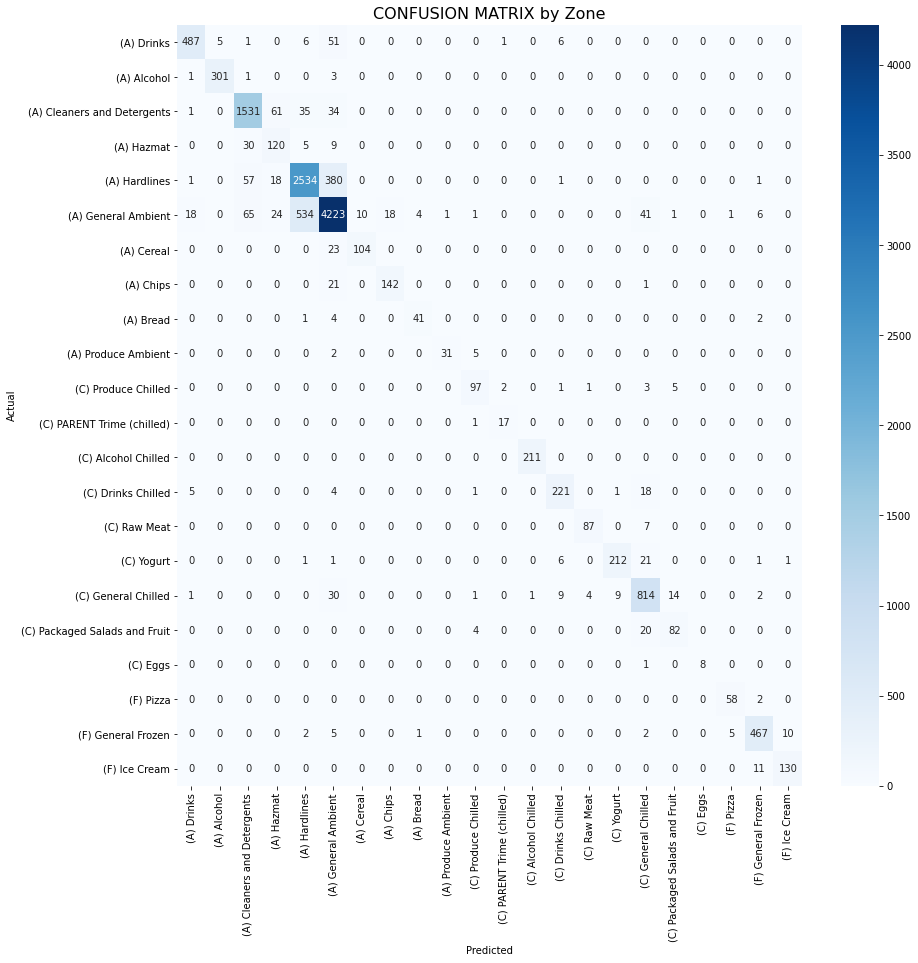

In [ ]:
# Reorder the confusion matrix (moving the 3 produce in adjacent to ambient and chilled)
conf_mat_reorder = confusion_matrix(ytest, prediction,
                                    labels=['Drinks', 'Alcohol', 'Cleaners and Detergents', 'Hazmat', 'Hardlines', 'General Ambient', 'Cereal', 'Chips', 'Bread', 'Produce Ambient', 'Produce Chilled', 'PARENT Trime (chilled)', 'Alcohol Chilled', 'Drinks Chilled', 'Raw Meat', 'Yogurt', 'General Chilled', 'Packaged Salads and Fruit', 'Eggs', 'Pizza', 'General Frozen', 'Ice Cream'])
descrip_reorder = ['(A) Drinks', '(A) Alcohol', '(A) Cleaners and Detergents', '(A) Hazmat', '(A) Hardlines', '(A) General Ambient', '(A) Cereal', '(A) Chips', '(A) Bread', '(A) Produce Ambient', '(C) Produce Chilled', '(C) PARENT Trime (chilled)', '(C) Alcohol Chilled', '(C) Drinks Chilled', '(C) Raw Meat', '(C) Yogurt', '(C) General Chilled', '(C) Packaged Salads and Fruit', '(C) Eggs', '(F) Pizza', '(F) General Frozen', '(F) Ice Cream']

# setup heat map
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(conf_mat_reorder, annot=True, cmap="Blues", fmt='d',
            xticklabels=descrip_reorder,yticklabels=descrip_reorder)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX by Zone", size=16);

Notice that Hazmat is only mis-classified as either 'Cleaners and Detergent', 'General Ambient', or 'Hardlines'.

**Heat map by temp zone**

Create a more general heat map that reports the mis-classification across the 3 temperature zones

In [ ]:
# confusion matrix by temp zone
conf_mat_zone = np.zeros((3,3)).astype(int)
conf_mat_zone[0,0] = conf_mat_reorder[0:10,0:10].sum()
conf_mat_zone[0,1] = conf_mat_reorder[0:10,10:19].sum()
conf_mat_zone[0,2] = conf_mat_reorder[0:10,19:22].sum()
conf_mat_zone[1,0] = conf_mat_reorder[10:19,0:10].sum()
conf_mat_zone[1,1] = conf_mat_reorder[10:19,10:19].sum()
conf_mat_zone[1,2] = conf_mat_reorder[10:19,19:22].sum()
conf_mat_zone[2,0] = conf_mat_reorder[19:22,0:10].sum()
conf_mat_zone[2,1] = conf_mat_reorder[19:22,10:19].sum()
conf_mat_zone[2,2] = conf_mat_reorder[19:22,19:22].sum()

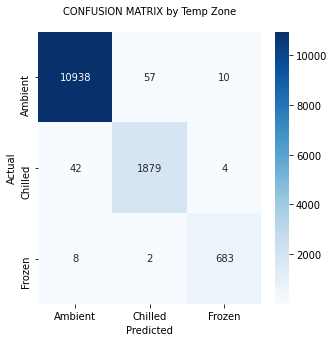

In [ ]:
# Create heatmap by temp zone
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_zone, annot=True, cmap="Blues", fmt='d',
            xticklabels=['Ambient','Chilled','Frozen'],yticklabels=['Ambient','Chilled','Frozen'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX by Temp Zone\n", size=10);

We care the most about the lower-left triangle:
- 42 chilled products mis-classified as ambient
- 8 frozen products mis-classified as ambient
- 2 frozen products mis-classified as chilled

Now let's zoom in further more with an error analysis

## 3.2 Error Analysis

Create a table with all the original information from the first 4 columns, and the new information of prediction and mis-classification

In [ ]:
# get the data with labels of validation set (# ASINs: 10914)
merged_1 = merged[merged.index.isin(ytest.index[()])].drop(columns=['not_english','combined']).rename(columns={'zone':'actual_temp_zone','descrip':'actual_zone'})

# order the data by the index of ytest
merged_2 = []
for i in ytest.index[()]:
    merged_2.append(merged_1[merged_1.index==i])
merged_3 = pd.concat(merged_2)

# add predicted labels to these ASINs
merged_3['pred_zone'] = prediction
merged_4 = pd.merge(merged_3, zone_referene, how='left', left_on='pred_zone', right_on='descrip').drop(columns=['pred_zone']).rename(columns={'zone':'pred_temp_zone','descrip':'pred_zone'})

# change actual and predicted temp zone to the 3 major zones
merged_4['actual_temp_zone'] = [sub[:-2] for sub in merged_4['actual_temp_zone']]
merged_4['pred_temp_zone'] = [sub[:-2] for sub in merged_4['pred_temp_zone']]

# add a column to show if it's misclassified
merged_4['misclass'] = (merged_4['actual_zone'] != merged_4['pred_zone']).map({True:'Y', False:'N'})
misclass = merged_4

Now, you can use the 'misclass' data frame to filter and check specific mis-classified instances by drop zone or temp zone, here're some examples:

In [ ]:
# If you're using Google Colab, you can just uncomment the line below
# and use the 'filter' function of the table viewer
# data_table.DataTable(test_df)

**Example 1:**

Chilled products mis-classified as ambient:

In [ ]:
misclass.loc[(misclass.actual_temp_zone=='chilled') & (misclass.pred_temp_zone=='ambient'),]

ASIN  ... misclassified
62     B000NQ10GO  ...             Y
241    B0177VSG78  ...             Y
286    B0794SZV3D  ...             Y
908    B06ZXX5Y93  ...             Y
926    B01HZNW822  ...             Y
1011   B00DM09GAA  ...             Y
1552   B078TSRN8X  ...             Y
1620   B07N9M1MF9  ...             Y
1969   B06ZZC444T  ...             Y
2808   B0799BK1GY  ...             Y
3888   B07F44XDD7  ...             Y
4128   B07HXPL74P  ...             Y
4396   B06XNTRK5P  ...             Y
5678   B006QATFAY  ...             Y
6528   B00KO8LO9E  ...             Y
7130   B00T4E18EA  ...             Y
7222   B07FN5WBJW  ...             Y
7334   B06WVJG2SR  ...             Y
7349   B000RLO56M  ...             Y
7463   B000WG7P5A  ...             Y
7680   B000VB263M  ...             Y
8513   B000RH19JC  ...             Y
8955   B06VV5KT6R  ...             Y
9167   B000WG4DHI  ...             Y
9899   B00374YHKU  ...             Y
10018  B07XZ47N78  ...             Y
10530  B00UO9T0WG  ...             Y
10794  B01N1OT468  ...             Y
10939  B07N4H1YFM  ...             Y
10999  B07JQ29GF5  ...             Y
11021  B000RGZ8Y0  ...             Y
11062  B0742FD4GV  ...             Y
11077  B006QATYD2  ...             Y
11630  B007QR5KPU  ...             Y
11716  B072M6V2RM  ...             Y
12258  B01LWSL98T  ...             Y
12405  B07FHPKFLZ  ...             Y
12549  B000VHJY5O  ...             Y
12594  B00T4E17WI  ...             Y
12765  B01BBLUT6Q  ...             Y
12985  B000VYPTW4  ...             Y
13555  B01F02BI44  ...             Y

[42 rows x 10 columns]

Notice that many chilled product has 'ambient' in its temp_zone column. 

Also, some products such as 'M&M Mint Chocolate Candy', 'Hershey's Chocolate Bar', 'Fever-Tree Sparkling Soda' seems like they can be stored in either ambient or chilled. In this case, whether it should be counted as mis-classification is questionable.

**Example 2:**

'Hazmat' mis-classified as 'Cleaners and Detergents'

In [ ]:
misclass.loc[(misclass.actual_zone=='Hazmat') & (misclass.pred_zone=='Cleaners and Detergents'),]

ASIN  ... misclass
101    B00U03ZUFW  ...        Y
903    B00OYPDLXK  ...        Y
906    B000ORSG6E  ...        Y
999    B004HGHZXI  ...        Y
1398   B01GTE3JGM  ...        Y
1445   B000KU7332  ...        Y
1769   B00XHDRDSE  ...        Y
2000   B00RBPX5TU  ...        Y
2283   B07RHVHKD4  ...        Y
2331   B0056A1WFG  ...        Y
2677   B008F8J22G  ...        Y
2918   B00E7W82J8  ...        Y
3966   B000RPKF7G  ...        Y
5293   B07NDDL2NV  ...        Y
5807   B00U7YNA7Y  ...        Y
6535   B000E7YJVU  ...        Y
7074   B006JY7AXQ  ...        Y
8087   B07845KZ8R  ...        Y
8688   B00BYQD39Y  ...        Y
9417   B015EFLJ4Q  ...        Y
10637  B00GTQ3CCM  ...        Y
10675  B00MA5SQUO  ...        Y
11754  B002EHUKCA  ...        Y
11964  B004C0PT14  ...        Y
12063  B001TICTG0  ...        Y
12420  B0048BDNGK  ...        Y
12951  B000NHAR94  ...        Y
12973  B00XI0XLRI  ...        Y
13500  B010VH2PK4  ...        Y
13506  B07CVK75HZ  ...        Y

[30 rows x 10 columns]

Notice that many instances have non-English item_name. Since they don't have non-English characters, they're not removed at the 'solve multi-language issue' section. An alternative method was to use language detecter to check the language for each item. But due to the limitation of Api, this apporach was not executed.

## 3.3 Keywords analysis

Let's check the most correlated words for the prediction of each drop zone to gain some intuitio of how the model works

In [ ]:
# a dict of layer1 for later use
zone_to_label_df1 = pd.DataFrame()
zone_to_label_df1['zone'] = np.unique(yval_CH)
zone_to_label_df1['label'] = range(0,21)
zone_to_label_1 = dict(zone_to_label_df1.values)

In [ ]:
# the top 5 correlated unigrams and bigrams
N=5

# Layer 1: 21 classes including 'Detergent and Hazmat'
for zone, label in sorted(zone_to_label_1.items()):
  indices = np.argsort(clf_l1.coef_[label])
  feature_names = np.array(ctv.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(zone))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))

# Layer 2: 'Hazmat'
indices = np.argsort(clf_l2.coef_[0])
feature_names = np.array(ctv.get_feature_names())[indices]
unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
print("\n==> 'Hazmat':")
print("  * Top unigrams: %s" %(', '.join(unigrams)))
print("  * Top bigrams: %s" %(', '.join(bigrams)))

# Layer 2: 'Detergent'
indices = np.argsort(clf_l2.coef_[0])
feature_names = np.array(ctv.get_feature_names())[indices]
unigrams = [v for v in feature_names if len(v.split(' ')) == 1][:N]
bigrams = [v for v in feature_names if len(v.split(' ')) == 2][:N]
print("\n==> 'Detergent':")
print("  * Top unigrams: %s" %(', '.join(unigrams)))
print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Alcohol':
  * Top unigrams: wine, spirit, docg, beer, proof
  * Top bigrams: beer ambient, wine ambient, spirit ambient, sparkle ambient, asian ambient

==> 'Alcohol Chilled':
  * Top unigrams: chill, wine, dorge, 6pk, malt
  * Top bigrams: wine chill, ambient chill, chill barley, natural oz, oz wine

==> 'Bread':
  * Top unigrams: bread, bakery, bun, muffins, rudi
  * Top bigrams: bakery ambient, oz bakery, reduce thiamin, mini muffins, muffins otis

==> 'Cereal':
  * Top unigrams: cereal, granola, maltomeal, breakfast, flake
  * Top bigrams: oat oil, cane corn, food ambient, everyday granola, salt sugar

==> 'Chips':
  * Top unigrams: chip, pretzel, popcorn, pringles, puff
  * Top bigrams: grocery ambient, oz popcorn, ounce pretzel, snack grocery, chia oil

==> 'Cleaners and Hazmat':
  * Top unigrams: licorice, detergent, laneige, sanitizer, bleach
  * Top bigrams: care skin, makeup ambient, fragrance ambient, unit ambient, speedwax appearance

==> 'Drinks':
  * Top unigrams: b

Interesting traits of Hazmat products: 
- Areosol products
- silver ml (liquid in silver bottles)
- permanent (indicators of strong chemicals)
- Glade (brand for air freshener)

## 3.4 Accuracy per class

Report the accuracy per class to calculate ROI in spreadsheet

In [ ]:
# Reorder the confusion matrix (moving the 3 produce in adjacent to ambient and chilled)
conf_mat_reorder = confusion_matrix(ytest, prediction,
                                    labels=['Drinks', 'Alcohol', 'Cleaners and Detergents', 'Hazmat', 'Hardlines', 'General Ambient', 'Cereal', 'Chips', 'Bread', 'Produce Ambient', 'Produce Chilled', 'PARENT Trime (chilled)', 'Alcohol Chilled', 'Drinks Chilled', 'Raw Meat', 'Yogurt', 'General Chilled', 'Packaged Salads and Fruit', 'Eggs', 'Pizza', 'General Frozen', 'Ice Cream'])
descrip_reorder = ['(A) Drinks', '(A) Alcohol', '(A) Cleaners and Detergents', '(A) Hazmat', '(A) Hardlines', '(A) General Ambient', '(A) Cereal', '(A) Chips', '(A) Bread', '(A) Produce Ambient', '(C) Produce Chilled', '(C) PARENT Trime (chilled)', '(C) Alcohol Chilled', '(C) Drinks Chilled', '(C) Raw Meat', '(C) Yogurt', '(C) General Chilled', '(C) Packaged Salads and Fruit', '(C) Eggs', '(F) Pizza', '(F) General Frozen', '(F) Ice Cream']

# Get accuracy per class
acc_per_class = conf_mat_reorder.diagonal() / conf_mat_reorder.sum(axis=1)

acc_per_class_df = pd.DataFrame({'zone':descrip_reorder, 'accuracy':acc_per_class})
print(acc_per_class_df)

                             zone  accuracy
0                      (A) Drinks  0.874327
1                     (A) Alcohol  0.983660
2     (A) Cleaners and Detergents  0.921179
3                      (A) Hazmat  0.731707
4                   (A) Hardlines  0.846925
5             (A) General Ambient  0.853649
6                      (A) Cereal  0.818898
7                       (A) Chips  0.865854
8                       (A) Bread  0.854167
9             (A) Produce Ambient  0.815789
10            (C) Produce Chilled  0.889908
11     (C) PARENT Trime (chilled)  0.944444
12            (C) Alcohol Chilled  1.000000
13             (C) Drinks Chilled  0.884000
14                   (C) Raw Meat  0.925532
15                     (C) Yogurt  0.872428
16            (C) General Chilled  0.919774
17  (C) Packaged Salads and Fruit  0.773585
18                       (C) Eggs  0.888889
19                      (F) Pizza  0.966667
20             (F) General Frozen  0.949187
21                  (F) Ice Crea

---
# Appendix

## 4.1 Pipeline & Tuning

Tune the best parameters for vectorizer and classifier

In [ ]:
# Pipeline
model = Pipeline([('vectorizer', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', SGDClassifier())])

In [ ]:
# Define customized scorer 
def haz_prec(y_ture, y_pred, average=None):
  return precision_score(y_ture, y_pred, average=average)[13]
def haz_recall(y_ture, y_pred, average=None):
  return recall_score(y_ture, y_pred, average=average)[13]
def haz_f1(y_ture, y_pred, average=None):
  return f1_score(y_ture, y_pred, average=average)[13]

customized_scorer = {'accuracy': make_scorer(accuracy_score), 
                     'avg_wgtd_prec':make_scorer(precision_score, average='weighted'),
                     'avg_wgtd_recall':make_scorer(recall_score, average='weighted'),
                     'avg_wgtd_f1':make_scorer(f1_score, average='weighted'),
                     'haz_prec':make_scorer(haz_prec, average=None),
                     'haz_recall':make_scorer(haz_recall, average=None),
                     'haz_f1':make_scorer(haz_f1, average=None)}

In [ ]:
# Setup parameters
parameters = {'vectorizer__stop_words': ['english'],
              'vectorizer__ngram_range': [(1,2)],
              'vectorizer__max_df': [0.75, 0.9, 1.0],
              'vectorizer__min_df': [0.0, 10],
              'vectorizer__max_features': [250000, 5000000],
              'tfidf__use_idf': [False],
              'clf__loss':['hinge'],
              'clf__penalty':['l2', None],
              'clf__alpha':[0.00001, 0.000001],
              'clf__class_weight': [class_weight]
              }

# a test parameter to make sure everything is working
parameters2 = {'clf__class_weight': [None], 'vectorizer__max_features':[100]}

In [ ]:
# run grid search to find the best parameter combination
gs_clf = GridSearchCV(model, parameters, n_jobs=-1, verbose=10, cv=3, scoring=customized_scorer, refit=False)
gs_clf = gs_clf.fit(xtrain, ytrain)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.7min finished


In [ ]:
# view result
# put result in a data frame
cv_result = pd.DataFrame({'param': gs_clf.cv_results_["params"], 
                          'average_accuracy': gs_clf.cv_results_["mean_test_accuracy"], 
                          'avg_wgtd_prec': gs_clf.cv_results_["mean_test_avg_wgtd_prec"],
                          'avg_wgtd_recall': gs_clf.cv_results_["mean_test_avg_wgtd_recall"],
                          'avg_wgtd_f1': gs_clf.cv_results_["mean_test_avg_wgtd_f1"],
                          'haz_prec': gs_clf.cv_results_["mean_test_haz_prec"],
                          'haz_recall': gs_clf.cv_results_["mean_test_haz_recall"],
                          'haz_f1': gs_clf.cv_results_["mean_test_haz_f1"],
                          'mean_fit_time':gs_clf.cv_results_["mean_fit_time"],
                          'mean_score_time':gs_clf.cv_results_["mean_score_time"],
                          })

# save grid search result in table form
cv_result.to_csv('/content/drive/MyDrive/MSBA_Capstone_Team_Amazon/grid_search_log/cv_result_may29.csv')

# save grid search model
filename = '/content/drive/MyDrive/MSBA_Capstone_Team_Amazon/grid_search_log/gs_clf_may29.sav'
pickle.dump(gs_clf, open(filename, 'wb'))

# load saved object
#pkl = pickle.load(open(filename, 'rb'))

## 4.2 Preliminary model selection

In [ ]:
# Try different models
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(),
    SGDClassifier(),
    RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0)
]

# 3 Cross-validation
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, xtrain_ctv, ytrain, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

In [ ]:
# Output the model results in table form
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

Mean Accuracy  Standard deviation
model_name                                               
LinearSVC                    0.863207            0.003014
LogisticRegression           0.866731            0.002237
MultinomialNB                0.818113            0.000781
RandomForestClassifier       0.391187            0.005125
SGDClassifier                0.867046            0.002210

## 4.3 Word Cloud Analysis

In [ ]:
merged

ASIN  ...          descrip
0      000824572X  ...        Hardlines
1      006242713X  ...  General Ambient
2      006280197X  ...        Hardlines
3      006282015X  ...  General Ambient
4      014240733X  ...  General Ambient
...           ...  ...              ...
68111  BT00CTP9JM  ...  General Ambient
68112  BT00CTPCO4  ...  General Ambient
68113  BT00KQAOCE  ...          Alcohol
68114  BT00KQKSZC  ...  Alcohol Chilled
68115  BT00KUUJKM  ...  Alcohol Chilled

[68113 rows x 9 columns]

In [ ]:
# First, get the information of zones in interest
hazmat = merged.loc[merged.descrip=='Hazmat'].combined
cleaners = merged.loc[merged.descrip=='Cleaners and Detergents'].combined

hardlines = merged.loc[merged.descrip=='Hardlines'].combined
general_ambient = merged.loc[merged.descrip=='General Ambient'].combined

In [ ]:
def wordcloud_analysis(zone1, zone2):
  ### Separate wordcloud for product1
  # reform words for visualization
  text1 = ''
  for t in zone1:
    lst1 = nltk.word_tokenize(t)
    text1 += ' '.join(lst1)
  
  token1 = nltk.word_tokenize(text1)
  print("There are {} unique words in zone1".format(len(token1)))
  print("Generating the first word cloud for zone1")

  # Generate a word cloud image
  wordcloud1 = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=800).generate(text1)

  # Display the generated image:
  # the matplotlib way:
  plt.figure(figsize=(16,9))
  plt.imshow(wordcloud1, interpolation='bilinear')
  plt.axis("off")
  plt.show()


  ### Separate wordcloud for product2
  text2 = ''
  for t in zone2:
    lst2 = nltk.word_tokenize(t)
    text2 += ' '.join(lst2)
  token2 = nltk.word_tokenize(text2)
  print("There are {} unique words in zone2".format(len(token2)))
  print("Generating the 2nd word cloud for zone2")

  # Generate a word cloud image
  wordcloud2 = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=800).generate(text2)

  # Display the generated image:
  # the matplotlib way:
  plt.figure(figsize=(16,9))
  plt.imshow(wordcloud2, interpolation='bilinear')
  plt.axis("off")
  plt.show()


  ### Cross-filtering
  filtered = ''

  # Get words in zone1 but not in zone2
  for word in token1:
    if word not in token2:
      filtered += ' ' + word
  token3 = nltk.word_tokenize(filtered)
  print("There are {} unique words in zone1 but not in zone2".format(len(np.unique(token3))))
  print('There percentage of unique words in zone1 but not in zone2is {}.'.format(len(np.unique(token3))/len(np.unique(token1))))
  print('generating the 3rd worcloud for word in zone1 but not in zone2')

    # Generate a word cloud image
  wordcloud3 = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=800).generate(filtered)

  # Display the generated image:
  # the matplotlib way:
  plt.figure(figsize=(16,9))
  plt.imshow(wordcloud3, interpolation='bilinear')
  plt.axis("off")
  plt.show()

There are 25363 unique words in zone1
Generating the first word cloud for zone


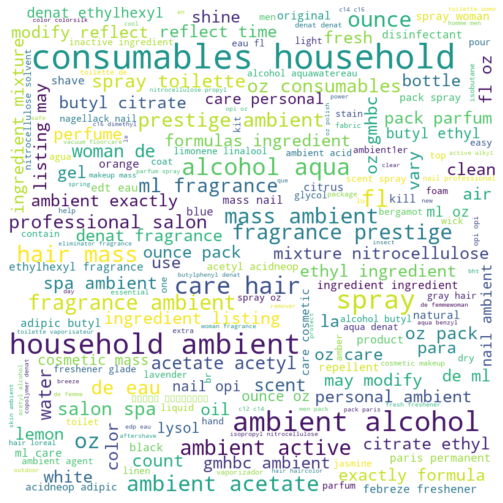

There are 153279 unique words in zone2
Generating the 2nd word cloud for zone2


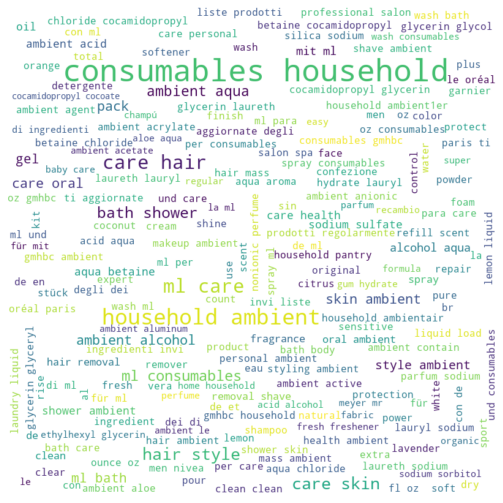

There are 2520 unique words in zone1 but not in zone2
There percentage of unique words in zone1 but not in zone2is 0.45104707356362983.
generating the 3rd worcloud for word in zone1 but not in zone2


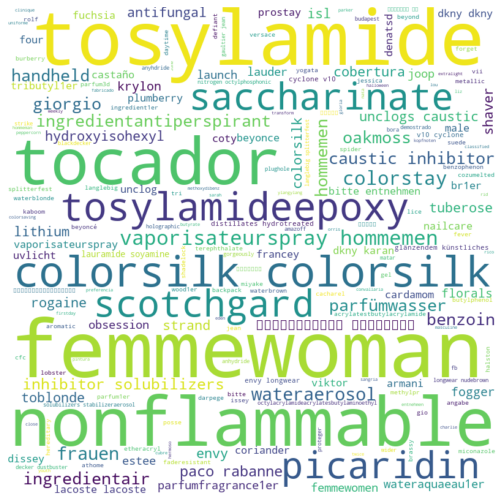

In [ ]:
wordcloud_analysis(hazmat, cleaners)